<a href="https://colab.research.google.com/github/Dyakonov/Colab/blob/main/dj_VKCup_4teach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Простое решение VKCup2022
Иллюстрация классификации на примере очень простой модели.
За базу взят код:
https://habr.com/ru/post/567028/

Для повышения качества надо
* менять модель
* почистить выборку (на половине обучиться, на другой запустить - посмотреть ошибки, там много "рекламных объявлений")
* можно смухлевать и то, в чём нет большой уверенности у трансформера - разметить вручную (таких групп не много)
* пополнить датасет (достаточно использовать wiki - страницы с указанными видами спорта + хорошо бы имена спортсменов и названия команд)
* аугментация (см. ниже EDA) + информация о длине сообщений

https://cups.online/

Интересно, что тут в коде автоматически в батче все последовательности токенов выравниваются по 512 токенов.

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 5.8 MB 45.3 MB/s 
     |████████████████████████████████| 7.6 MB 56.5 MB/s 
     |████████████████████████████████| 182 kB 73.4 MB/s 


* Прикинуть, сколько токенов получается
* И может, аугментацию впихнуть

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/VKcup2022/train.csv')
print (train.shape)
train.head()

In [ ]:
test = pd.read_csv('/content/drive/My Drive/VKcup2022/test.csv')
print (test.shape)
test.head()

(26260, 2)


,oid,text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...
1,452466036,Естественное восстановление после тяжелой трен...
2,161038103,Тема нарядов продолжается Одна из британских ж...
3,663621910,Привет Избранный. Ты спрашиваешь себя ЧТО здес...
4,566255305,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...


# EDA

Задача - по oid определить тему группы (канала, который постит сообщения)

* для каждого oid даны 10 сообщений на тему спорта (в обучении и тесте), т.е. ответов в 10 раз меньше, чем строк в тесте
* есть мусор (см. первое сообщение теста) - его много и он всё портит
* некоторые сообщения (баскетбол / футбол) сложно различить
* баланс классов - пропорции классов примерно одинаковы
* интересно, но пропорции зависят от oid (в начале и конце датасета они разные, не проверял на стат значимость, не пользовался)
* есть длинные сообщения - выйдут за 512 токенов (по хорошему их надо делить на части)


In [ ]:
train.sort_values(by='oid', inplace=True)
train.head()

,oid,category,text
36670,16594,extreme,wortokenoid wenkextokenoid zhotokenoid wenzhou...
29568,16594,extreme,Кто ваш комфорт персонаж и почему? Стала поним...
33867,16594,extreme,Письма не отсюда OJV первый альбом на русском ...
547,16594,extreme,Пост для обсуждения наболевшего по китайским ф...
32307,16594,extreme,Письма не отсюда первый альбом на русском язык...


In [ ]:
# распределение по классам
train.category.value_counts(normalize=True)

autosport       0.081569
extreme         0.080279
martial_arts    0.078730
motosport       0.078214
boardgames      0.077956
tennis          0.077439
esport          0.077181
athletics       0.076665
hockey          0.076149
volleyball      0.076149
football        0.073826
basketball      0.073567
winter_sport    0.072277
Name: category, dtype: float64

In [ ]:
# в начале выборки
train.head(1000).category.value_counts(normalize=True)

martial_arts    0.13
autosport       0.10
motosport       0.10
tennis          0.10
winter_sport    0.09
athletics       0.08
hockey          0.08
extreme         0.07
boardgames      0.06
basketball      0.06
football        0.05
volleyball      0.05
esport          0.03
Name: category, dtype: float64

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train.category)
labels = le.transform(train.category)
train['labels'] = labels # делаем перекодировку в цифры
pd.crosstab(train.category, train.labels)

labels,0,1,2,3,4,5,6,7,8,9,10,11,12
category,,,,,,,,,,,,,
athletics,2970,0,0,0,0,0,0,0,0,0,0,0,0
autosport,0,3160,0,0,0,0,0,0,0,0,0,0,0
basketball,0,0,2850,0,0,0,0,0,0,0,0,0,0
boardgames,0,0,0,3020,0,0,0,0,0,0,0,0,0
esport,0,0,0,0,2990,0,0,0,0,0,0,0,0
extreme,0,0,0,0,0,3110,0,0,0,0,0,0,0
football,0,0,0,0,0,0,2860,0,0,0,0,0,0
hockey,0,0,0,0,0,0,0,2950,0,0,0,0,0
martial_arts,0,0,0,0,0,0,0,0,3050,0,0,0,0


In [ ]:
# метки
le.classes_

array(['athletics', 'autosport', 'basketball', 'boardgames', 'esport',
       'extreme', 'football', 'hockey', 'martial_arts', 'motosport',
       'tennis', 'volleyball', 'winter_sport'], dtype=object)

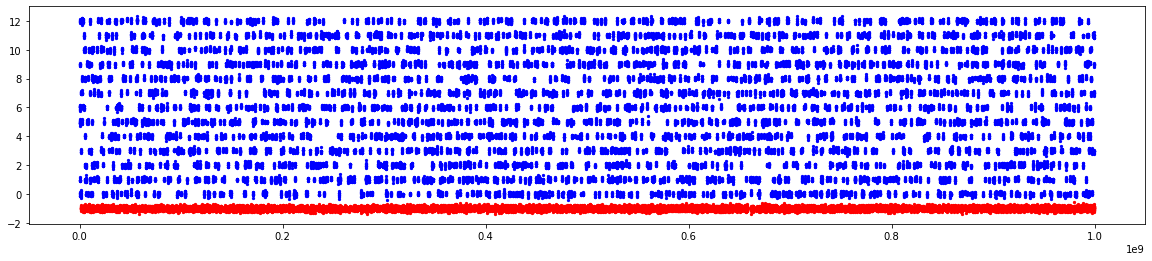

In [ ]:
# распределение по категориям в зависимости от oid
from matplotlib import pyplot as plt
import numpy as np
plt.figure(figsize=(20, 4))
plt.scatter(train.oid, train.labels + 0.1*np.random.randn(38740),5, c='b')
plt.scatter(test.oid, - 1 + 0.1*np.random.randn(26260),5, c='r')

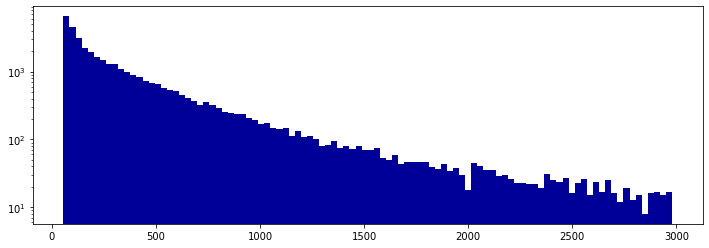

In [ ]:
# распределение длин
train['lens'] = train.text.str.len()
plt.figure(figsize=(12, 4))
plt.hist(train.lens.values, bins=100, color='#000099');
plt.yscale('log')

In [ ]:
# длина по категориям
train.groupby('category')['lens'].median()

category
athletics       319.0
autosport       249.0
basketball      144.0
boardgames      366.0
esport          150.0
extreme         277.0
football        143.0
hockey          183.5
martial_arts    188.5
motosport       301.0
tennis          213.0
volleyball      208.5
winter_sport    265.0
Name: lens, dtype: float64

In [ ]:
train[train.oid == 365271984]

,oid,category,text,labels,lens
9795,365271984,winter_sport,По заявкам публики Евгения Медведева и Торнике...,12,135
15301,365271984,winter_sport,Сегодня Женя комментировала короткую программу...,12,100
8529,365271984,winter_sport,24 апреля 18 55 Первый канал ️ ЕвгенияМедведев...,12,61
9813,365271984,winter_sport,Кружочки с шоу Влюбленные в фигурное катание и...,12,93
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,65
13013,365271984,winter_sport,Женя на хоккее ЕвгенияМедведева Evgentokenoid ...,12,56
24972,365271984,winter_sport,Еще немного видео с ребятами А теперь внимание...,12,97
5802,365271984,winter_sport,Саша Трусова о Жене Моховая 9 ЕвгенияМедведева...,12,60
24225,365271984,winter_sport,Женя рассказывает о первом дне в Карелии ️ YAP...,12,79
23211,365271984,winter_sport,Последний совместный номер Жени Медведевой и Д...,12,99


# Модель

Взято с модификациями здесь: https://habr.com/ru/post/567028/

In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='/content/bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features # ??????? не используется
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    def preparation(self, X_train, y_train, X_valid, y_valid, batch_size=2):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=batch_size, shuffle=True) # BS здесь ввёл параметр
        self.valid_loader = DataLoader(self.valid_set, batch_size=batch_size, shuffle=False)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0, # можно по-другому
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)

    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in self.train_loader:
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss

    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses) # можно более хитрую метрику вставить!!!
        return val_acc, val_loss

    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)

    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }

        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)

        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )

        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

    def predict_proba(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }

        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)

        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )

        prediction = outputs.logits.detach().cpu().numpy()

        return prediction

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(train.category)
# labels = le.transform(train.category)

# train['labels'] = labels

# pd.crosstab(train.category, train.labels)

# Эксперименты

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_nottrain, y_train, y_nottrain = train_test_split(train.text.values, train.labels.values, test_size=0.4, random_state=1)
#X_valid, X_test, y_valid, y_test = train_test_split(X_nottrain, y_nottrain, test_size=0.4, random_state=2)
#print (X_train.shape, y_train.shape,
#       X_valid.shape, y_valid.shape,
#       X_test.shape, y_test.shape)


# после сортировки по oid - надо без перемешивания, чтобы было разбиение по oid
# здесь фиктивный тест 10 записей с одним oid

from sklearn.model_selection import train_test_split
X_train, X_nottrain, y_train, y_nottrain = train_test_split(train.text.values, train.labels.values, test_size=10010, random_state=1, shuffle=False)
X_valid, X_test, y_valid, y_test = train_test_split(X_nottrain, y_nottrain, test_size=10, random_state=2, shuffle=False)
print (X_train.shape, y_train.shape,
       X_valid.shape, y_valid.shape,
       X_test.shape, y_test.shape)

(28730,) (28730,) (10000,) (10000,) (10,) (10,)


In [ ]:
# лучше использовать маленькую дистиллированную модель - cointegrated/rubert-tiny
# ИНАЧЕ ОЧЕНЬ ДОЛГО ОБУЧАЕТСЯ - DeepPavlov/rubert-base-cased (но зато качество лучше)

classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny', # 'cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny', # 'cointegrated/rubert-tiny',
        n_classes=13,
        epochs=1, # тут надо минимум 3-4 эпохи, можно и 10
        model_save_path='/content/bert.pt')

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [ ]:
classifier.device

device(type='cuda', index=0)

In [ ]:
classifier.preparation(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid,
        batch_size=32 # лучше 16
    ) # train.text.values, train.labels.values

In [ ]:
%%time

classifier.train()

#Epoch 1/2
#Train loss 1.2627708217729128 accuracy 0.6139648941662365
#Val loss 0.9252895122721605 accuracy 0.7439339184305628
#----------
#Epoch 2/2
#Train loss 0.8376717758583517 accuracy 0.7710699535363965
#Val loss 0.9077642973224964 accuracy 0.7732318017552917
#----------


#Epoch 1/4
#Train loss 1.3542041437821053 accuracy 0.5759765961108243
#Val loss 0.9952788275730039 accuracy 0.7123803377433581
#----------
#Epoch 2/4
#Train loss 0.8627688049968835 accuracy 0.7634228187919464
#Val loss 0.945814811862751 accuracy 0.7688501667204475
#----------
#Epoch 3/4
#Train loss 0.7019202396355955 accuracy 0.8218034761658923
#Val loss 0.9846865316208151 accuracy 0.7849844035710445
#----------
#Epoch 4/4
#Train loss 0.602789018603445 accuracy 0.8523059714334883
#Val loss 1.0038791963433615 accuracy 0.7901473593632354

# BS=16
#Train loss 0.7593215192627759 accuracy 0.7746945448287731
#Val loss 0.8601838096886668 accuracy 0.7386253630203291
#----------
#CPU times: user 15min 52s, sys: 2.65 s, total: 15min 55s
#Wall time: 15min 57s


# №Epoch 1/4
# Train loss 1.560910131877156 accuracy 0.526673550163483
# Val loss 1.1343602184782322 accuracy 0.659352479294396
# ----------
# Epoch 2/4
# Train loss 1.0023222442175386 accuracy 0.7038805713302358
# Val loss 0.9500910761378885 accuracy 0.7095837366892546
# ----------
# Epoch 3/4
# Train loss 0.8365279270691127 accuracy 0.7527103768714507
# Val loss 0.8794595258009598 accuracy 0.734107776702162
# ----------
# Epoch 4/4
# Train loss 0.7593215192627759 accuracy 0.7746945448287731
# Val loss 0.8601838096886668 accuracy 0.7386253630203291
# ----------
# CPU times: user 15min 52s, sys: 2.65 s, total: 15min 55s
# Wall time: 15min 57s


# качество на большой моделе
# Epoch 1/4
# Train loss 0.6860053262109131 accuracy 0.7963104768534632
# Val loss 0.448870500805974 accuracy 0.869

Epoch 1/1
Train loss 1.6548265534015434 accuracy 0.5067525234946049
Val loss 1.2997211571128224 accuracy 0.6252
----------
CPU times: user 4min 54s, sys: 1.01 s, total: 4min 55s
Wall time: 5min 16s


In [ ]:
# для очистки памяти
torch.cuda.empty_cache()

In [ ]:
# на валидации
predictions_p = [classifier.predict_proba(t) for t in X_valid]
predictions_p = np.concatenate(predictions_p)
np.mean(np.argmax(predictions_p, axis=1) == y_valid) # точность, но по текстам

0.6252

In [ ]:
# softmax
P = np.exp(predictions_p) / np.exp(predictions_p).sum(axis=1)[:, np.newaxis]

# кладём в датафрейм
tmp = pd.DataFrame(P)
#tmp.head()
tmp.shape

(10000, 13)

In [ ]:
# это просто имитация oid: 0...0 1...1 2...2... (они идут десятками)
tmp['oid'] = sum([[i]*10 for i in range(1000)], [])

In [ ]:
# правильные ответы
tmp['y'] = y_valid

tmp2 = tmp.groupby('oid')[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'y'].mean()

a = np.argmax(tmp2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values, axis=1)
y = tmp2['y'].astype('int')

# точность, но уже по группам (если поучить, то будет - 0.978)
np.mean(a == y)

<ipython-input-41-106c25988c46>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp2 = tmp.groupby('oid')[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'y'].mean()


0.851

In [ ]:
# ЭТО КАЧЕСТВО ОРГАНИЗАТОРОВ
q = np.max(tmp2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values, axis=1) > 0.1
sum(0.0 + ((a == y) & q) - ((a != y) & q)) / len(a)

0.702

Text(0.5, 0, 'порог')

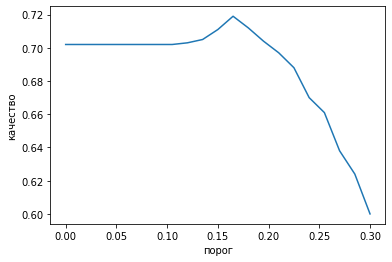

In [ ]:
e = []
ls = np.linspace(0.0, .3, 21)
for th in ls:
  q = np.max(tmp2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values, axis=1) >  th
  e.append(sum(0.0 + ((a == y) & q) - ((a != y) & q)) / len(a))

from matplotlib import pyplot as plt
plt.plot(ls, e)
plt.ylabel('качество')
plt.xlabel('порог')

([<matplotlib.axis.YTick at 0x7f8d45b3ca00>,
 [Text(0, 0, 'неверно'), Text(0, 0, 'верно')])

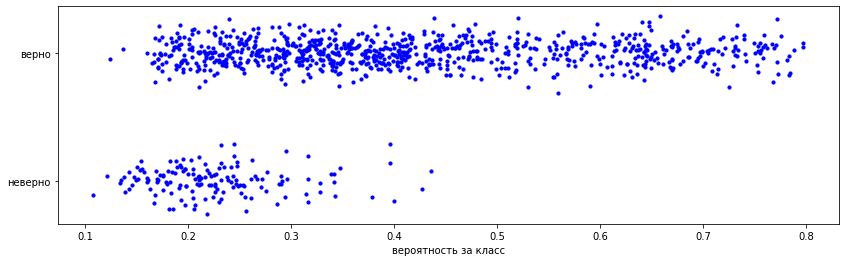

In [ ]:
M = tmp2[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values
a = np.argmax(M, axis=1)

plt.figure(figsize=(14, 4))
plt.scatter(np.max(M, axis=1), (a == y) + 0.0 + 0.1*np.random.randn(len(a)), 10, c='b')
plt.xlabel('вероятность за класс')
plt.yticks([0,1], ['неверно', 'верно'])

Тут ещё можно сделать эксперименты, как усреднять вероятности текстов одного oid: mean(norm), prod(norm), norm(mean) и т.п.

Но лучше - mean

И тут надо смотреть на ошибки алгоритма!

# Делаем обучение на всём датасете

In [ ]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=13,
        epochs=10,
        model_save_path='/content/bert.pt')

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [ ]:
classifier.preparation(
        X_train=train.text.values,
        y_train=train.labels.values,
        X_valid=train.text.values[:16],
        y_valid=train.labels.values[:16],
        batch_size=16
    ) # train.text.values, train.labels.values

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
%%time

classifier.train()


#Epoch 5/5
#Train loss 0.5504407701086373 accuracy 0.8373773877129582
#Val loss 0.4624370845015516 accuracy 0.8649782222939184
#----------
#CPU times: user 30min 10s, sys: 4.97 s, total: 30min 15s
#Wall time: 30min 28s

#Epoch 5/5
#Train loss 0.5465716854457664 accuracy 0.8358802271553949
#Val loss 0.45308029646841214 accuracy 0.864816905952573
#----------
#CPU times: user 30min 41s, sys: 6.7 s, total: 30min 48s
#Wall time: 31min

Epoch 1/10
Train loss 1.3555976924548752 accuracy 0.5879194630872483
Val loss 0.6656747460365295 accuracy 0.8125
----------
Epoch 2/10
Train loss 0.8098507011901437 accuracy 0.759137842023748
Val loss 0.5020994544029236 accuracy 0.875
----------
Epoch 3/10
Train loss 0.6387307417911995 accuracy 0.8072534847702633
Val loss 0.5709105730056763 accuracy 0.875
----------
Epoch 4/10
Train loss 0.5332978347971618 accuracy 0.8403200826019618
Val loss 0.5031685829162598 accuracy 0.875
----------
Epoch 5/10
Train loss 0.4626872512241972 accuracy 0.8617707795560144
Val loss 0.5350421667098999 accuracy 0.875
----------
Epoch 6/10
Train loss 0.4089182420513761 accuracy 0.8792720702116675
Val loss 0.5102961659431458 accuracy 0.875
----------
Epoch 7/10
Train loss 0.36910413785258495 accuracy 0.8916107382550336
Val loss 0.4925006330013275 accuracy 0.875
----------
Epoch 8/10
Train loss 0.34095316444324447 accuracy 0.8992514197212184
Val loss 0.5115657448768616 accuracy 0.875
----------
Epoch 9/10
Tra

In [ ]:
test = pd.read_csv('/content/drive/My Drive/VKcup2022/test.csv')
test.head()

,oid,text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...
1,452466036,Естественное восстановление после тяжелой трен...
2,161038103,Тема нарядов продолжается Одна из британских ж...
3,663621910,Привет Избранный. Ты спрашиваешь себя ЧТО здес...
4,566255305,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...


In [ ]:
# ответы на тесте
predictions_p = [classifier.predict_proba(t) for t in test.text.values]
predictions_p = np.concatenate(predictions_p)

# softmax
P = np.exp(predictions_p) / np.exp(predictions_p).sum(axis=1)[:, np.newaxis]

# ответы - НЕ НАДО, см. дальше
# a = np.argmax(P, axis=1)

# q = np.max(P, axis=1) > 0.57

In [ ]:
# датафрейм с ответами
tmp = pd.DataFrame(P)
tmp['oid'] = test.oid.values
tmp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,oid
0,0.015539,0.137882,0.140147,0.001415,0.171159,0.162377,0.152165,0.034634,0.114597,0.016915,0.014718,0.022401,0.016051,749208109
1,0.107065,0.008851,0.017514,0.005140,0.014875,0.316986,0.004792,0.003956,0.476649,0.003846,0.003557,0.017439,0.019330,452466036
2,0.004109,0.016045,0.007592,0.006323,0.006950,0.076866,0.004125,0.003793,0.277978,0.008530,0.248962,0.004254,0.334474,161038103
3,0.008106,0.007162,0.007690,0.084492,0.243526,0.465978,0.009851,0.005214,0.010962,0.021296,0.022575,0.108133,0.005014,663621910
4,0.000265,0.000464,0.002515,0.001099,0.000774,0.000226,0.000771,0.003915,0.000480,0.000318,0.986531,0.001613,0.001027,566255305


In [ ]:
# получаем среднее вероятностей по всем текстам в группе (для каждого oid)
tmp2 = tmp.groupby('oid')[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12].mean()

<ipython-input-27-8f01ac118680>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp2 = tmp.groupby('oid')[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12].mean()


In [ ]:
tmp2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
oid,,,,,,,,,,,,,
1622114,0.476017,0.014515,0.036526,0.049224,0.196903,0.057132,0.026904,0.008067,0.036455,0.023198,0.003296,0.059666,0.012098
1663817,0.009714,0.516631,0.028313,0.049216,0.048800,0.033054,0.042696,0.028734,0.026084,0.062197,0.012655,0.039660,0.102246
3174332,0.002995,0.007566,0.627390,0.003556,0.013542,0.003958,0.098107,0.102170,0.118330,0.002318,0.007089,0.002758,0.010220
3469228,0.040695,0.043929,0.086507,0.011273,0.109555,0.254681,0.030913,0.012924,0.220486,0.047532,0.005738,0.014080,0.121687
3905302,0.062515,0.003637,0.005665,0.592561,0.015584,0.022135,0.073394,0.035068,0.139191,0.011710,0.003616,0.012519,0.022405


In [ ]:
a = np.argmax(tmp2.values, axis=1) # ответы-метки для каждого oid
q = np.max(tmp2.values, axis=1) # вероятность для каждого oid
# np.mean(q)

tmp2['q'] = q
tmp2['category'] = le.classes_[a]

tmp3 = tmp2.reset_index()[['oid', 'q', 'category']]

In [ ]:
tmp3.head()

,oid,q,category
0,1622114,0.476017,athletics
1,1663817,0.516631,autosport
2,3174332,0.627390,basketball
3,3469228,0.254681,extreme
4,3905302,0.592561,boardgames


In [ ]:
# ОТВЕТЫ
# tmp3.loc[tmp3.q,['oid', 'category']].to_csv('/content/drive/My Drive/VKcup2022/my_subm_2_01.csv', index=False)
tmp3[['oid', 'category']].to_csv('/content/drive/My Drive/VKcup2022/my_subm_2_01.csv', index=False)

## используем данный организаторами submission

In [ ]:
ss = pd.read_csv('/content/drive/My Drive/VKcup2022/sample_submission.csv')

In [ ]:
ss = ss.rename(columns={'category': 'cat2'})

In [ ]:
tmp4 = tmp3.merge(ss)
tmp4

,oid,q,category,cat2
0,1622114,0.476017,athletics,athletics
1,1663817,0.516631,autosport,autosport
2,3174332,0.627390,basketball,basketball
3,3469228,0.254681,extreme,extreme
4,3905302,0.592561,boardgames,boardgames
...,...,...,...,...
2621,998309713,0.613303,esport,esport
2622,998565619,0.680576,esport,esport
2623,999112505,0.987478,boardgames,boardgames
2624,999361308,0.892935,tennis,tennis


In [ ]:
np.mean(tmp4.category == tmp4.cat2) # 0.940974866717441

0.9390708301599391

In [ ]:
tmp4.cat2.value_counts(dropna=False)

athletics       228
volleyball      220
winter_sport    219
hockey          214
boardgames      204
tennis          203
extreme         202
motosport       199
esport          198
autosport       194
basketball      194
football        182
martial_arts    169
Name: cat2, dtype: int64

In [ ]:
tmp4.category.value_counts(dropna=False)

winter_sport    224
basketball      211
esport          211
athletics       209
motosport       207
football        204
volleyball      202
tennis          201
martial_arts    199
boardgames      198
hockey          198
extreme         187
autosport       175
Name: category, dtype: int64

In [ ]:
# выдаём ответ, в котором достаточно уверны + когда совпадает метка с сабмишеном

tmp4.loc[(tmp4.q > 0.25) | (tmp4.category == tmp4.cat2), ['oid', 'category']].to_csv('/content/drive/My Drive/VKcup2022/my_subm_2_03.csv', index=False)

In [ ]:
np.mean((tmp4.q > 0.25) | (tmp4.category == tmp4.cat2))

0.9859101294744859

In [ ]:
# сохранить
np.save('/content/drive/My Drive/VKcup2022/file_predictions_p2', predictions_p)

In [ ]:
M1 = np.load('/content/drive/My Drive/VKcup2022/file_predictions_p.npy')
M2 = np.load('/content/drive/My Drive/VKcup2022/file_predictions_p2.npy')

In [ ]:
M1

array([[ 0.38715988,  2.1464462 ,  0.6602676 , ..., -2.187107  ,
        -0.9280837 , -2.0909786 ],
       [-1.8438573 ,  1.1789752 ,  0.05604577, ..., -2.269684  ,
        -0.6526191 , -2.098324  ],
       [-2.2933254 , -0.7430721 , -2.001864  , ...,  3.5871646 ,
        -1.6867396 ,  2.9348774 ],
       ...,
       [-2.4737365 ,  1.5882375 ,  0.43417102, ..., -0.5331661 ,
        -0.37016618, -2.7066557 ],
       [ 0.3106244 , -0.6740804 , -1.8826008 , ..., -1.52554   ,
        -0.41385028,  2.4165974 ],
       [ 7.6467957 , -0.66276574, -0.523138  , ..., -0.7851571 ,
         1.2715926 , -0.72937673]], dtype=float32)

In [ ]:
M2

array([[-0.874328  ,  1.3087137 ,  1.3250055 , ..., -0.92861235,
        -0.50857425, -0.84191704],
       [ 1.8336079 , -0.6592827 ,  0.02315136, ..., -1.5709826 ,
         0.01885811,  0.12181805],
       [-1.6422126 , -0.27997994, -1.0283302 , ...,  2.4619126 ,
        -1.6076217 ,  2.7571728 ],
       ...,
       [-1.3070832 , -0.03124756, -1.6049141 , ..., -1.8747405 ,
         0.41502583, -2.418354  ],
       [ 2.5573685 , -0.5868255 , -1.2443544 , ..., -2.3048878 ,
        -0.97534144,  0.814234  ],
       [ 6.7464886 , -1.6292963 ,  0.48985252, ..., -0.8863347 ,
         1.0378687 , -0.1931099 ]], dtype=float32)